## STIX Exploration

Deltares is working on a new version of their stability software. The old software used complicating (DOS time based) left to right geometries and much more old stuff which is now much better organized and flexible. They also changed the file structure which now consists of a zipped collection of json files (yeah.. thx Deltares for using JSON instead of the awful XML! ;-)

In this notebook I am looking into some details of the stix file. My main goal is to see how it is build up and how I can change properties in the files to automate creation of stix files. The final goal is to connect this kind of code to my library so I can easily create stix files from input sources like boreholes / crosssections / cone penetration tests etc. etc. 

But first things first, let look at the new way these files are put together...

### STIX - what it is

A stix file is actually a zip file and it contains a number of json files. JSON is a great descriptive and webservice ready exchange format that is easily read by Pythons native json library so way to go Deltares!

![dsuite](https://bitbucket.org/breinbaas/stix_exploration/raw/6e645ba5da56d2f0ab2355805f42aef518778c7b/dsuite.jpg)

If you unzip a stix file you will (with my simple geometry calculation) get these files / directories;

**Note that DSuite is still in beta so changes are still very likely**

* calculationsettings.json
* decorations.json
* geometries.json
* loads.json
* reinforcements.json
* results.json
* soillayers.json
* stages.json
* states.json
* waternetcreatorsettings.json
* waternets.json
* nailpropertiesforsoils.json
* projectinfo.json
* soils.json

Some files can be found in subdirectories and I guess this is because it will be possible to have more json files in for example the results directory.

If you open up a JSON file (note, please use a nice JSON viewer (notepad++ with json plugin or vscode etc.)) you will see things like;

```
{
  "Soils": [
    {
      "Id": "1",
      "Name": "Embankment new",
      "Code": "H_Aa_ht_new",
      "VolumetricWeightAbovePhreaticLevel": 19.3,
      "VolumetricWeightBelowPhreaticLevel": 19.3,
      "ShearStrengthModelTypeAbovePhreaticLevel": "CPhi",
      "ShearStrengthModelTypeBelowPhreaticLevel": "Su",
      "Cohesion": 7.0,
      "FrictionAngle": 30.0,
      "Dilatancy": 0.0,
      "ShearStrengthRatio": 0.26,
      "StrengthIncreaseExponent": 0.9
    },
```

Wow.. that's easy.. everything is easy to find.. finally! Compare this to the old .sti.. oh dear..

### Let's write a partial stix reader

Ok, we now know a little about the structure so how can we read these files.. easy! Python off course. 

For my journey I decided to write a STIX class that could read the geometry properties to plot the geometry. I wanted to see if I could read the soil details (like names and parameters and the geometry). Just to show that I could do it the final proof had to be a simple plot of the geometry..

So here's the code;

In [1]:
# import libs to make life easier
from zipfile import ZipFile
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np

# my object uses different names for the properties so I need a dictionary to translate between the 
# Deltares names and my names
dict_soilparameters = {
    'id':'Id',
    'name':'Name',
    'code':'Code',
    'ydry':'VolumetricWeightAbovePhreaticLevel',
    'ysat':'VolumetricWeightBelowPhreaticLevel',
    'c':'Cohesion',
    'phi':'FrictionAngle',
    'dilatancy':'Dilatancy'
}

# are you serious with Python, write OOP code! ;-)
# here's the object to store the soils
class STIXSoil:
    def __init__(self):
        self.id = -1
        self.name = ""
        self.code = ""
        self.ydry = 0.
        self.ysat = 0.
        self.c = 0.
        self.phi = 0.        
        self.dilatancy = 0.

# introducing the layers
class STIXLayer:
    def __init__(self):
        self.id = -1
        self.label = None
        self.points = []
        self.soilid = -1

# one class to rule them all
class STIX:
    def __init__(self):
        self._layers = {}
        self._soils = {}
        
    def limits(self):
        """Returns the limits of all layers as a dictionary"""
        limit = [1e9,-1e9,-1e9,1e9] #[left, top, right, bottom]
        for l in self._layers.values():
            for p in l.points:
                if p[0] < limit[0]:
                    limit[0] = p[0]
                if p[0] > limit[2]:
                    limit[2] = p[0]
                if p[1] < limit[3]:
                    limit[3] = p[1]
                if p[1] > limit[1]:
                    limit[1] = p[1]
        return {"xmin":limit[0],"zmax":limit[1],"xmax":limit[2],"zmin":limit[3]}
    
    def from_file(self, filename):
        """Read a stix file and get the geometry as well as soils"""
        input_zip = ZipFile(filename)
        data = {name.replace('.json',''): json.loads(input_zip.read(name).decode("utf-8")) for name in input_zip.namelist()} 
        self._parse_geometry(data['geometries/geometry'])
        self._parse_soils(data['soils'])
        self._parse_soillayers(data['soillayers/soillayers'])
        
    def _parse_geometry(self, data):        
        """Parse the geometry from json to python classes"""
        for layer in data['Layers']:
            stlayer = STIXLayer()
            stlayer.id = layer['Id']
            stlayer.label = layer['Label']            
            for point in layer['Points']:
                stlayer.points.append((point['X'], point['Z']))
            self._layers[layer['Id']] = stlayer
            
    def _parse_soillayers(self, data):
        """Connect the layers to the right soil"""
        soillayerdict = {}
        for soillayer in data['SoilLayers']:
            soillayerdict[soillayer['LayerId']] = soillayer['SoilId']
            
        for k in self._layers.keys():
            try:
                self._layers[k].soilid = soillayerdict[k]
            except:
                print("Whoops, there seems to be a layer (id=%s) with an unvalid soilid (soilid=%s)" % (k, self._layers[k].soilid))
    
    def _parse_soils(self, data):
        """Parse the soil information from json to python classes"""
        for soil in data['Soils']:
            stsoil = STIXSoil()
            stsoil.id = soil[dict_soilparameters['id']]
            stsoil.name = soil[dict_soilparameters['name']]
            stsoil.code = soil[dict_soilparameters['code']]
            stsoil.ydry = soil[dict_soilparameters['ydry']]
            stsoil.ysat = soil[dict_soilparameters['ysat']]
            stsoil.c = soil[dict_soilparameters['c']]
            stsoil.phi = soil[dict_soilparameters['phi']]        
            stsoil.dilatancy = soil[dict_soilparameters['dilatancy']]
            self._soils[soil[dict_soilparameters['id']]] = stsoil
            
    def soils_as_dataframe(self):
        """Convenience function that returns the available soils as a pandas dataframe"""        
        values = list(self._soils.values())
        ids = [s.code for s in values]
        names = [s.name for s in values]
        codes = [s.code for s in values]
        ydrys = [s.ydry for s in values]
        ysats = [s.ysat for s in values]
        cs = [s.c for s in values]
        phis = [s.phi for s in values]
        dilatancies = [s.dilatancy for s in values]
        dict_df = {'id':ids,'name':names,'code':codes,'ydry':ydrys,'ysat':ysats,'c':cs,'phi':phis,'dilatancy':dilatancies}
        return pd.DataFrame.from_dict(dict_df)
    
    def plot(self):
        """Show off how incredibely beautiful the result is"""
        limits = self.limits()        
        patches = []
        for layer in self._layers.values():
            polygon = Polygon(layer.points)
            patches.append(polygon)
            
        p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
        colors = 100*np.random.rand(len(patches)) #yeah, I know.. would have been better to give the same color to the same soillayers..
        p.set_array(np.array(colors))

        fig, ax = plt.subplots(figsize=(15,10))
        ax.add_collection(p)
        ax.set_xlim([limits['xmin'],limits['xmax']])
        ax.set_ylim([limits['zmin'],limits['zmax']])
        plt.show()

### Result

Ok, let's see how this behaves.. we load a stix file and plot the result...

In [2]:
stix = STIX()
stix.from_file('G:\\Data\\Documents\\waternet\\dsuite_test\\test.stix')

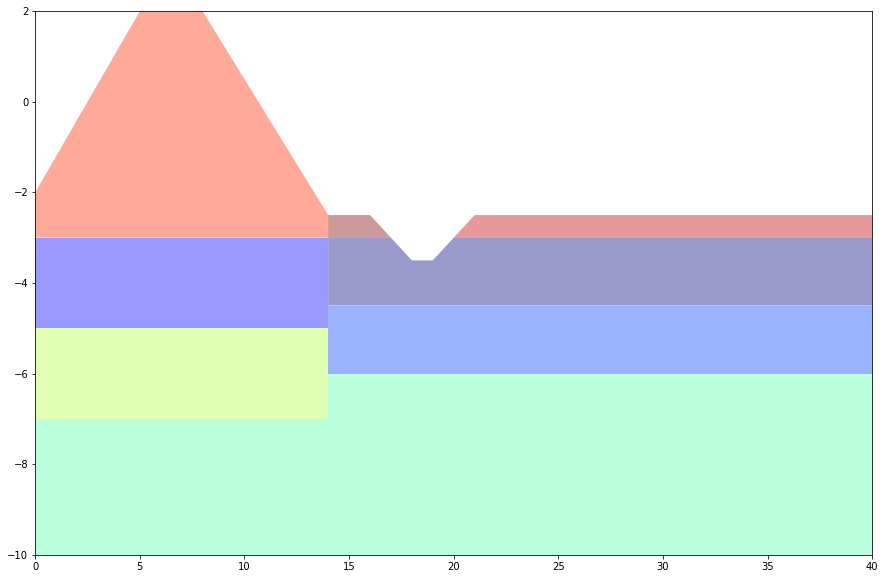

In [3]:
stix.plot()

Yeah.. seems like we got it right!

I also like to see if this will load the soil parameters...

In [4]:
stix.soils_as_dataframe()

id            name            code  ydry  ysat    c   phi  \
0      H_Aa_ht_new  Embankment new     H_Aa_ht_new  19.3  19.3  7.0  30.0   
1      H_Aa_ht_old  Embankment old     H_Aa_ht_old  18.0  18.0  7.0  30.0   
2   H_Rk_k_shallow   Clay, shallow  H_Rk_k_shallow  14.8  14.8  0.0   0.0   
3      H_Rk_k_deep      Clay, deep     H_Rk_k_deep  15.6  15.6  0.0   0.0   
4          H_Rk_ko    Organic clay         H_Rk_ko  13.9  13.9  0.0   0.0   
5          H_vhv_v   Peat, shallow         H_vhv_v  10.1  10.1  0.0   0.0   
6          H_vbv_v      Peat, deep         H_vbv_v  11.0  11.0  0.0   0.0   
7             Sand            Sand            Sand  18.0  20.0  0.0  30.0   
8         P_Rk_k&s  Clay with silt        P_Rk_k&s  18.0  18.0  0.0   0.0   
9         H_Ro_z&k  Sand with clay        H_Ro_z&k  18.0  18.0  0.0   0.0   
10      Material_K               K      Material_K  14.0  14.0  5.0  22.0   
11    Material_Vk2             Vk2    Material_Vk2  10.5  10.5  2.0  18.0   
12  Material_Z_ZMG           Z ZMG  Material_Z_ZMG  17.0  19.0  0.0  30.0   

    dilatancy  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  
10       22.0  
11       18.0  
12       30.0

Again.. great succes! 

### Next up

This is just a small exploration of the new stix file. Next up is (off course) manipulation of the stix file! I want to create them myself and not just read those made by DSuite.. Things are very hopeful for this because of the new and great way of implementing JSON and using polygon geometries instead of the old left-right lines. 

I will be working on this soon and probably post about this as well. In the meantime, if you use this code or enhance this code, don't be an ..fill in any kind of insulting word.. and tell me or post your code as well.

Many thanks to Raymond van der Meij (Deltares) for getting me up to speed and I'm looking forward to the next step!

Rob